Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV ,StratifiedKFold

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Dataset analysis

1. Use RIDAGEYR columns to make another group to the age_group. 
Make a function that changes peoples group from "Adult" to "Young" if they are from age 12 to 25.
2. After that, remove RIDAGEYR. 
3. Rename columns to be more comprehensive.


       SEQN age_group  RIDAGEYR  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  \
0   73564.0     Adult      61.0       2.0     2.0    35.7   110.0     2.0   
1   73568.0     Adult      26.0       2.0     2.0    20.3    89.0     2.0   
2   73576.0     Adult      16.0       1.0     2.0    23.2    89.0     2.0   
3   73577.0     Adult      32.0       1.0     2.0    28.9   104.0     2.0   
4   73580.0     Adult      38.0       2.0     1.0    35.9   103.0     2.0   
5   73581.0     Adult      50.0       1.0     2.0    23.6   110.0     2.0   
6   73587.0     Adult      14.0       1.0     2.0    38.7    94.0     2.0   
7   73596.0     Adult      57.0       2.0     2.0    38.3   107.0     2.0   
8   73607.0    Senior      75.0       1.0     2.0    38.9    89.0     2.0   
9   73610.0     Adult      43.0       1.0     1.0    28.9    90.0     2.0   
10  73618.0     Adult      54.0       2.0     2.0    32.7    98.0     2.0   
11  73619.0     Adult      36.0       2.0     1.0    27.3    85.0     2.0   

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


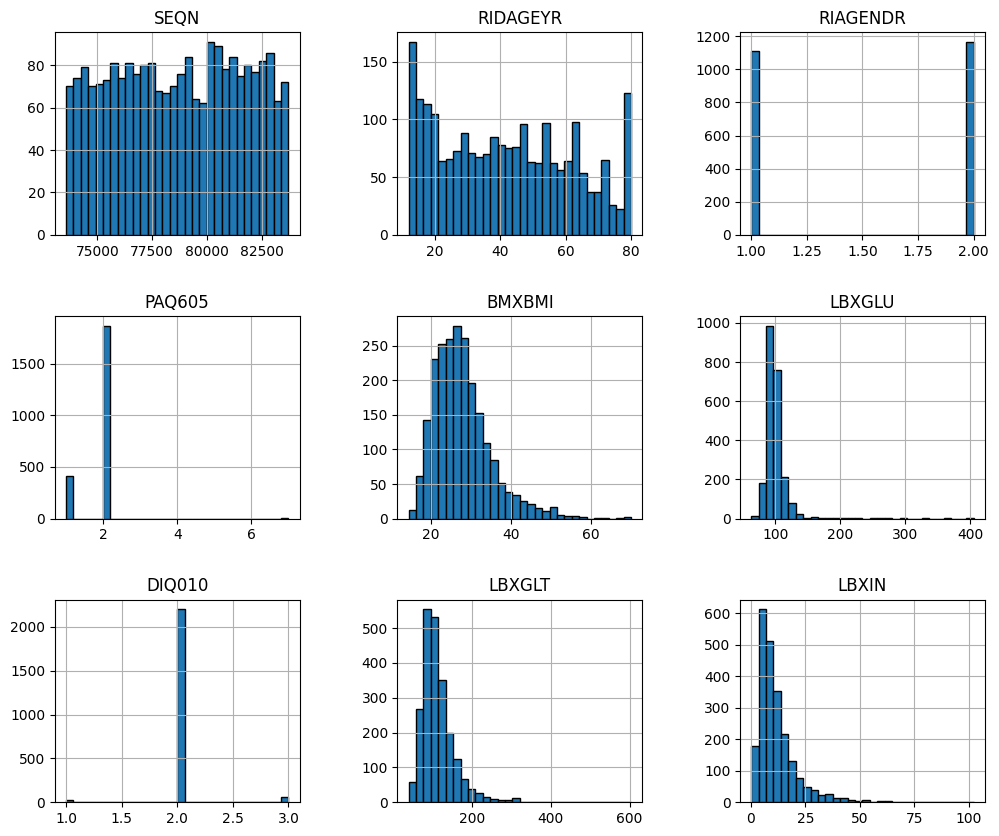

In [32]:
df = pd.read_csv("NHANES_age_prediction.csv")
print(df.head(20))

df.hist(figsize=(12,10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.4, wspace=0.4)
df.describe()

In [15]:
X = df.drop(columns = 'age_group')
y = df['age_group']


In [16]:
categories_order = [['Adult', 'Senior']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
df['age_group'] = ordinal_encoder.fit_transform(df[['age_group']])

<Axes: >

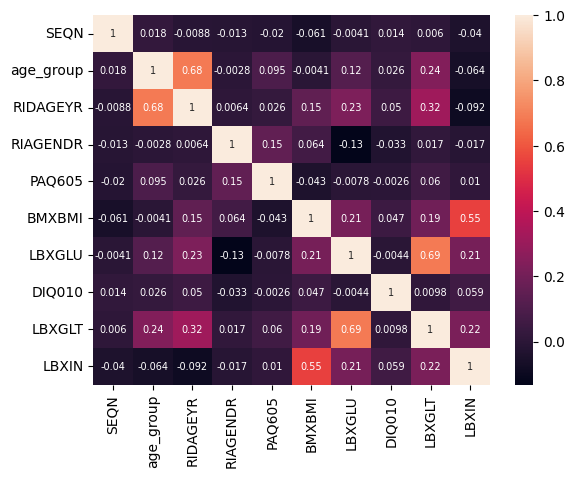

In [31]:
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 7})

1. Take models and train on X_train, y_train
2. Predict age_group
3. Plot metrics like accuracy_score, confussion_matrix, etc.
4. Tune hyperparameters of the models using tune_parameters.

# Model training and evaluation

In [18]:
def dropOutliers(df, drop_list):
    for col in drop_list:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        clean_data = df[(df[col] > lower_bound) 
                        & (df[col] < upper_bound)]
        df = clean_data
    return df

# function to tune hyperparameters of a selected model
# how to write param_grid
param_grid = {
    'classification__penalty': ['l1', 'l2', 'elasticnet', None],
    'classification__max_iter': [100, 200, 500],
    'classification__solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'classification__multi_class': ['auto', 'ovr', 'multinomial']
}

def tune_hyperparams(model, param_grid, X_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('regressor', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
